In [1]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd
#from tqdm import tqdm

# Math
import numpy as np
import scipy.stats
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa
import librosa.display
from scipy import sparse, stats, spatial
import scipy.sparse.linalg

# Machine learning
from sklearn.neural_network import MLPClassifier
from sklearn.utils import shuffle
from sklearn.metrics import  confusion_matrix

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import pandas as pd

%matplotlib inline

In [2]:
features_og = pd.read_pickle('./Features Data/trainingFeatures.pickle')

#### Spectral clustering

In [3]:
# drop features
features = pd.DataFrame(features_og['mfcc'])
features -= features.mean(axis=0)
features /= features.std(axis=0)

distances = spatial.distance.squareform(spatial.distance.pdist(features,'cosine'))

n=distances.shape[0]
kernel_width = distances.mean()
weights = np.exp(np.divide(-np.square(distances),kernel_width**2))
np.fill_diagonal(weights,0)

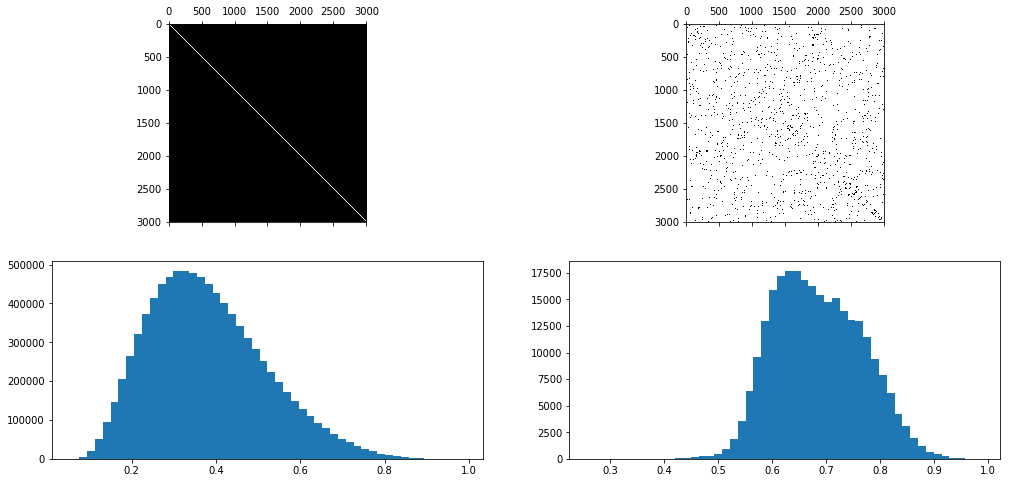

In [4]:
fix, axes = plt.subplots(2, 2, figsize=(17, 8))
def plot(weights, axes):
    axes[0].spy(weights)
    axes[1].hist(weights[weights > 0].reshape(-1), bins=50);
plot(weights, axes[:, 0])

NEIGHBORS = 120

for i in range(weights.shape[0]):
    idx = weights[i,:].argsort()[:-NEIGHBORS]
    weights[i,idx] = 0
    weights[idx,i] = 0

plot(weights, axes[:, 1])
   

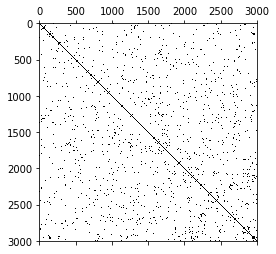

In [5]:
degrees = np.sum(weights,axis=0)
laplacian = np.diag(degrees**-0.5) @ (np.diag(degrees) - weights) @ np.diag(degrees**-0.5)
laplacian = sparse.csr_matrix(laplacian)
plt.spy(laplacian.todense());

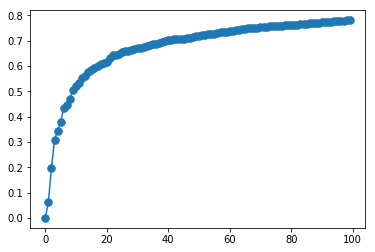

In [6]:
eigenvalues, eigenvectors = sparse.linalg.eigsh(A=laplacian,k=100,which='SM')
plt.plot(eigenvalues, '.-', markersize=15);


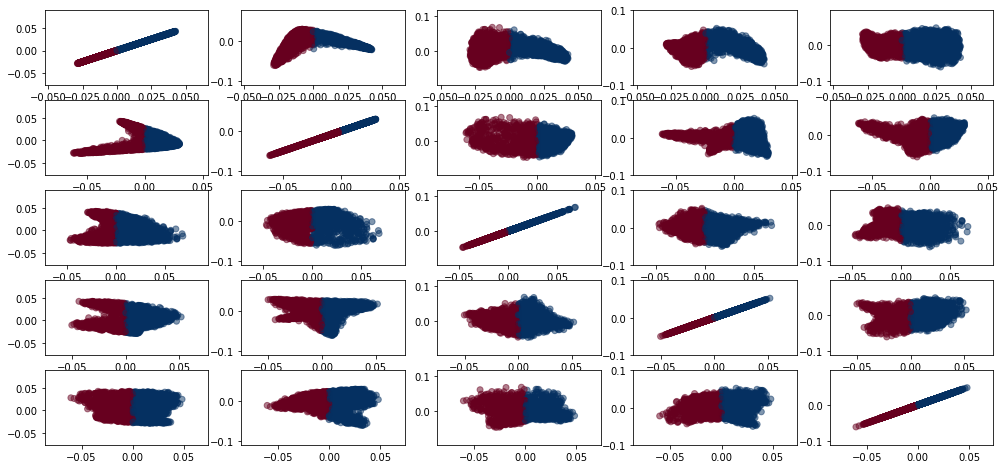

In [7]:
fix, axes = plt.subplots(5, 5, figsize=(17, 8))
for i in range(1,6):
    for j in range(1,6):
        x = eigenvectors[:,i]
        y = eigenvectors[:,j]
        labels = np.sign(x)
        axes[i-1,j-1].scatter(x, y, c=labels, cmap='RdBu', alpha=0.5)

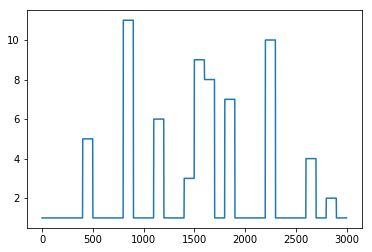

In [80]:
#features_og['mfcc']

# Stolen code from Manuel

# Build Label vector
# Define class name vector, the index will correspond to the calss label
class_names = ['unknown','yes','no','up','down','left','right','on','off','stop','go']
label_vec = np.ones(len(features_og))
for i in range(0,len(class_names)):
    label_vec +=(features_og['info','word'] == class_names[i]) * i
    
#equalize label count
#label_vec = label_vec[1800:]    

label_vec.plot()

In [81]:
# sample classes such as test and train have equal proportion of classes

train_size = 80
test_size = 20

train_x = np.array([])
train_y = np.array([])

test_x = np.array([])
test_y = np.array([])

for i in range(len(class_names)):
    class_index = np.where(label_vec == (i+1))[0]
    
    random_index = np.random.randint(low=0, high=len(class_index), size=train_size+test_size)
    
    train_x_class = class_index[random_index[:train_size]]
    train_y_class = label_vec[train_x_class]
    train_x = np.append(train_x, train_x_class)
    train_y = np.append(train_y, train_y_class)

    test_x_class = class_index[random_index[train_size:train_size+test_size]]
    test_y_class = label_vec[test_x_class]
    test_x = np.append(test_x, test_x_class)
    test_y = np.append(test_y, test_y_class)
    

In [82]:
# get features
train_features = eigenvectors[train_x.astype(int),:]
test_features = eigenvectors[test_x.astype(int),:]


Build neural network :

In [83]:
clf = MLPClassifier(hidden_layer_sizes=(30, ), 
                    activation='logistic', 
                    solver='adam', 
                    alpha=0.0001, 
                    learning_rate='adaptive',
                    learning_rate_init=0.001, 
                    power_t=0.5, 
                    max_iter=10000,
                    tol=1e-6, 
                    verbose=True)


In [84]:
clf.fit(train_features, train_y)  

Iteration 1, loss = 2.47494963
Iteration 2, loss = 2.45403219
Iteration 3, loss = 2.43707894
Iteration 4, loss = 2.42547402
Iteration 5, loss = 2.41587772
Iteration 6, loss = 2.40883565
Iteration 7, loss = 2.40493315
Iteration 8, loss = 2.40168363
Iteration 9, loss = 2.39953406
Iteration 10, loss = 2.39752444
Iteration 11, loss = 2.39639200
Iteration 12, loss = 2.39577857
Iteration 13, loss = 2.39531113
Iteration 14, loss = 2.39469979
Iteration 15, loss = 2.39426519
Iteration 16, loss = 2.39385914
Iteration 17, loss = 2.39367866
Iteration 18, loss = 2.39345937
Iteration 19, loss = 2.39320165
Iteration 20, loss = 2.39285878
Iteration 21, loss = 2.39275770
Iteration 22, loss = 2.39236370
Iteration 23, loss = 2.39197241
Iteration 24, loss = 2.39171412
Iteration 25, loss = 2.39144051
Iteration 26, loss = 2.39112416
Iteration 27, loss = 2.39087919
Iteration 28, loss = 2.39071582
Iteration 29, loss = 2.39031300
Iteration 30, loss = 2.38999795
Iteration 31, loss = 2.38963558
Iteration 32, los

Iteration 270, loss = 2.20522301
Iteration 271, loss = 2.20356601
Iteration 272, loss = 2.20184905
Iteration 273, loss = 2.20025281
Iteration 274, loss = 2.19870930
Iteration 275, loss = 2.19699139
Iteration 276, loss = 2.19550187
Iteration 277, loss = 2.19374693
Iteration 278, loss = 2.19216529
Iteration 279, loss = 2.19047023
Iteration 280, loss = 2.18870181
Iteration 281, loss = 2.18723170
Iteration 282, loss = 2.18522114
Iteration 283, loss = 2.18369229
Iteration 284, loss = 2.18207855
Iteration 285, loss = 2.18042665
Iteration 286, loss = 2.17849312
Iteration 287, loss = 2.17694845
Iteration 288, loss = 2.17525703
Iteration 289, loss = 2.17337157
Iteration 290, loss = 2.17142905
Iteration 291, loss = 2.16990046
Iteration 292, loss = 2.16787714
Iteration 293, loss = 2.16625621
Iteration 294, loss = 2.16471167
Iteration 295, loss = 2.16275490
Iteration 296, loss = 2.16110611
Iteration 297, loss = 2.15927626
Iteration 298, loss = 2.15726878
Iteration 299, loss = 2.15556506
Iteration 

Iteration 521, loss = 1.69847005
Iteration 522, loss = 1.69648860
Iteration 523, loss = 1.69463127
Iteration 524, loss = 1.69262795
Iteration 525, loss = 1.69068584
Iteration 526, loss = 1.68878664
Iteration 527, loss = 1.68679490
Iteration 528, loss = 1.68496581
Iteration 529, loss = 1.68311314
Iteration 530, loss = 1.68136549
Iteration 531, loss = 1.67953467
Iteration 532, loss = 1.67752733
Iteration 533, loss = 1.67570972
Iteration 534, loss = 1.67381888
Iteration 535, loss = 1.67180977
Iteration 536, loss = 1.67011978
Iteration 537, loss = 1.66843450
Iteration 538, loss = 1.66675696
Iteration 539, loss = 1.66474967
Iteration 540, loss = 1.66286468
Iteration 541, loss = 1.66090302
Iteration 542, loss = 1.65949461
Iteration 543, loss = 1.65722500
Iteration 544, loss = 1.65538005
Iteration 545, loss = 1.65355477
Iteration 546, loss = 1.65198103
Iteration 547, loss = 1.65008053
Iteration 548, loss = 1.64840031
Iteration 549, loss = 1.64683194
Iteration 550, loss = 1.64469974
Iteration 

Iteration 791, loss = 1.30313440
Iteration 792, loss = 1.30221597
Iteration 793, loss = 1.30102929
Iteration 794, loss = 1.29993934
Iteration 795, loss = 1.29879643
Iteration 796, loss = 1.29773713
Iteration 797, loss = 1.29667617
Iteration 798, loss = 1.29566125
Iteration 799, loss = 1.29475990
Iteration 800, loss = 1.29347252
Iteration 801, loss = 1.29259348
Iteration 802, loss = 1.29154382
Iteration 803, loss = 1.29040352
Iteration 804, loss = 1.28956290
Iteration 805, loss = 1.28828665
Iteration 806, loss = 1.28717255
Iteration 807, loss = 1.28623584
Iteration 808, loss = 1.28517638
Iteration 809, loss = 1.28409785
Iteration 810, loss = 1.28299233
Iteration 811, loss = 1.28207092
Iteration 812, loss = 1.28103280
Iteration 813, loss = 1.27998136
Iteration 814, loss = 1.27894305
Iteration 815, loss = 1.27793265
Iteration 816, loss = 1.27680446
Iteration 817, loss = 1.27584437
Iteration 818, loss = 1.27478648
Iteration 819, loss = 1.27382745
Iteration 820, loss = 1.27274857
Iteration 

Iteration 1070, loss = 1.07338739
Iteration 1071, loss = 1.07268568
Iteration 1072, loss = 1.07230313
Iteration 1073, loss = 1.07149913
Iteration 1074, loss = 1.07082153
Iteration 1075, loss = 1.07010719
Iteration 1076, loss = 1.06952294
Iteration 1077, loss = 1.06886926
Iteration 1078, loss = 1.06832357
Iteration 1079, loss = 1.06785500
Iteration 1080, loss = 1.06704552
Iteration 1081, loss = 1.06649108
Iteration 1082, loss = 1.06576684
Iteration 1083, loss = 1.06519900
Iteration 1084, loss = 1.06461658
Iteration 1085, loss = 1.06398820
Iteration 1086, loss = 1.06340342
Iteration 1087, loss = 1.06274811
Iteration 1088, loss = 1.06235660
Iteration 1089, loss = 1.06154378
Iteration 1090, loss = 1.06106652
Iteration 1091, loss = 1.06027476
Iteration 1092, loss = 1.05964692
Iteration 1093, loss = 1.05899554
Iteration 1094, loss = 1.05855489
Iteration 1095, loss = 1.05782422
Iteration 1096, loss = 1.05734572
Iteration 1097, loss = 1.05667472
Iteration 1098, loss = 1.05609098
Iteration 1099

Iteration 1345, loss = 0.92973745
Iteration 1346, loss = 0.92918937
Iteration 1347, loss = 0.92886800
Iteration 1348, loss = 0.92841803
Iteration 1349, loss = 0.92803081
Iteration 1350, loss = 0.92767819
Iteration 1351, loss = 0.92717765
Iteration 1352, loss = 0.92677703
Iteration 1353, loss = 0.92641588
Iteration 1354, loss = 0.92589861
Iteration 1355, loss = 0.92549196
Iteration 1356, loss = 0.92500176
Iteration 1357, loss = 0.92456502
Iteration 1358, loss = 0.92439840
Iteration 1359, loss = 0.92385208
Iteration 1360, loss = 0.92341961
Iteration 1361, loss = 0.92293240
Iteration 1362, loss = 0.92252322
Iteration 1363, loss = 0.92215886
Iteration 1364, loss = 0.92164709
Iteration 1365, loss = 0.92107118
Iteration 1366, loss = 0.92061276
Iteration 1367, loss = 0.92034441
Iteration 1368, loss = 0.91988659
Iteration 1369, loss = 0.91934826
Iteration 1370, loss = 0.91911198
Iteration 1371, loss = 0.91853134
Iteration 1372, loss = 0.91800014
Iteration 1373, loss = 0.91756232
Iteration 1374

Iteration 1585, loss = 0.83692003
Iteration 1586, loss = 0.83660705
Iteration 1587, loss = 0.83625474
Iteration 1588, loss = 0.83596732
Iteration 1589, loss = 0.83580788
Iteration 1590, loss = 0.83532128
Iteration 1591, loss = 0.83488207
Iteration 1592, loss = 0.83456331
Iteration 1593, loss = 0.83427203
Iteration 1594, loss = 0.83390638
Iteration 1595, loss = 0.83350180
Iteration 1596, loss = 0.83312730
Iteration 1597, loss = 0.83294695
Iteration 1598, loss = 0.83256418
Iteration 1599, loss = 0.83225967
Iteration 1600, loss = 0.83178270
Iteration 1601, loss = 0.83169211
Iteration 1602, loss = 0.83116728
Iteration 1603, loss = 0.83078454
Iteration 1604, loss = 0.83042209
Iteration 1605, loss = 0.83019915
Iteration 1606, loss = 0.82971911
Iteration 1607, loss = 0.82960340
Iteration 1608, loss = 0.82914510
Iteration 1609, loss = 0.82882309
Iteration 1610, loss = 0.82844559
Iteration 1611, loss = 0.82808604
Iteration 1612, loss = 0.82778213
Iteration 1613, loss = 0.82748413
Iteration 1614

Iteration 1825, loss = 0.76293539
Iteration 1826, loss = 0.76260385
Iteration 1827, loss = 0.76236845
Iteration 1828, loss = 0.76203929
Iteration 1829, loss = 0.76171126
Iteration 1830, loss = 0.76151534
Iteration 1831, loss = 0.76123719
Iteration 1832, loss = 0.76105336
Iteration 1833, loss = 0.76071461
Iteration 1834, loss = 0.76043386
Iteration 1835, loss = 0.76018107
Iteration 1836, loss = 0.75982588
Iteration 1837, loss = 0.75961177
Iteration 1838, loss = 0.75923893
Iteration 1839, loss = 0.75904822
Iteration 1840, loss = 0.75862453
Iteration 1841, loss = 0.75843559
Iteration 1842, loss = 0.75808201
Iteration 1843, loss = 0.75784381
Iteration 1844, loss = 0.75762672
Iteration 1845, loss = 0.75737925
Iteration 1846, loss = 0.75719799
Iteration 1847, loss = 0.75683991
Iteration 1848, loss = 0.75665802
Iteration 1849, loss = 0.75630659
Iteration 1850, loss = 0.75600714
Iteration 1851, loss = 0.75582347
Iteration 1852, loss = 0.75537758
Iteration 1853, loss = 0.75516049
Iteration 1854

Iteration 2103, loss = 0.69361971
Iteration 2104, loss = 0.69348888
Iteration 2105, loss = 0.69311427
Iteration 2106, loss = 0.69301745
Iteration 2107, loss = 0.69266377
Iteration 2108, loss = 0.69250698
Iteration 2109, loss = 0.69227049
Iteration 2110, loss = 0.69207249
Iteration 2111, loss = 0.69185518
Iteration 2112, loss = 0.69167001
Iteration 2113, loss = 0.69144223
Iteration 2114, loss = 0.69111119
Iteration 2115, loss = 0.69078447
Iteration 2116, loss = 0.69063258
Iteration 2117, loss = 0.69044005
Iteration 2118, loss = 0.69027061
Iteration 2119, loss = 0.69013100
Iteration 2120, loss = 0.68985695
Iteration 2121, loss = 0.68946988
Iteration 2122, loss = 0.68936149
Iteration 2123, loss = 0.68904341
Iteration 2124, loss = 0.68880959
Iteration 2125, loss = 0.68874177
Iteration 2126, loss = 0.68839188
Iteration 2127, loss = 0.68818680
Iteration 2128, loss = 0.68801808
Iteration 2129, loss = 0.68796428
Iteration 2130, loss = 0.68771919
Iteration 2131, loss = 0.68730909
Iteration 2132

Iteration 2381, loss = 0.63675732
Iteration 2382, loss = 0.63668194
Iteration 2383, loss = 0.63646513
Iteration 2384, loss = 0.63615688
Iteration 2385, loss = 0.63615590
Iteration 2386, loss = 0.63590249
Iteration 2387, loss = 0.63569646
Iteration 2388, loss = 0.63549850
Iteration 2389, loss = 0.63529804
Iteration 2390, loss = 0.63514616
Iteration 2391, loss = 0.63484650
Iteration 2392, loss = 0.63468827
Iteration 2393, loss = 0.63452820
Iteration 2394, loss = 0.63446044
Iteration 2395, loss = 0.63412684
Iteration 2396, loss = 0.63407085
Iteration 2397, loss = 0.63398806
Iteration 2398, loss = 0.63378885
Iteration 2399, loss = 0.63359167
Iteration 2400, loss = 0.63337012
Iteration 2401, loss = 0.63333809
Iteration 2402, loss = 0.63306691
Iteration 2403, loss = 0.63279404
Iteration 2404, loss = 0.63259835
Iteration 2405, loss = 0.63231242
Iteration 2406, loss = 0.63212183
Iteration 2407, loss = 0.63197016
Iteration 2408, loss = 0.63174515
Iteration 2409, loss = 0.63156280
Iteration 2410

Iteration 2660, loss = 0.58893869
Iteration 2661, loss = 0.58876884
Iteration 2662, loss = 0.58858335
Iteration 2663, loss = 0.58843761
Iteration 2664, loss = 0.58810762
Iteration 2665, loss = 0.58811636
Iteration 2666, loss = 0.58800608
Iteration 2667, loss = 0.58790527
Iteration 2668, loss = 0.58766161
Iteration 2669, loss = 0.58727937
Iteration 2670, loss = 0.58735567
Iteration 2671, loss = 0.58714948
Iteration 2672, loss = 0.58705316
Iteration 2673, loss = 0.58696423
Iteration 2674, loss = 0.58657867
Iteration 2675, loss = 0.58643526
Iteration 2676, loss = 0.58629353
Iteration 2677, loss = 0.58611841
Iteration 2678, loss = 0.58606625
Iteration 2679, loss = 0.58590363
Iteration 2680, loss = 0.58566127
Iteration 2681, loss = 0.58560827
Iteration 2682, loss = 0.58534561
Iteration 2683, loss = 0.58521085
Iteration 2684, loss = 0.58508899
Iteration 2685, loss = 0.58486088
Iteration 2686, loss = 0.58476559
Iteration 2687, loss = 0.58469456
Iteration 2688, loss = 0.58441100
Iteration 2689

Iteration 2901, loss = 0.55289457
Iteration 2902, loss = 0.55269462
Iteration 2903, loss = 0.55253077
Iteration 2904, loss = 0.55240057
Iteration 2905, loss = 0.55221918
Iteration 2906, loss = 0.55201904
Iteration 2907, loss = 0.55181270
Iteration 2908, loss = 0.55168883
Iteration 2909, loss = 0.55162544
Iteration 2910, loss = 0.55143596
Iteration 2911, loss = 0.55142508
Iteration 2912, loss = 0.55131542
Iteration 2913, loss = 0.55110933
Iteration 2914, loss = 0.55088667
Iteration 2915, loss = 0.55084889
Iteration 2916, loss = 0.55073902
Iteration 2917, loss = 0.55066630
Iteration 2918, loss = 0.55044336
Iteration 2919, loss = 0.55034095
Iteration 2920, loss = 0.55009179
Iteration 2921, loss = 0.54993009
Iteration 2922, loss = 0.54968363
Iteration 2923, loss = 0.54970513
Iteration 2924, loss = 0.54966110
Iteration 2925, loss = 0.54949308
Iteration 2926, loss = 0.54922144
Iteration 2927, loss = 0.54909820
Iteration 2928, loss = 0.54891898
Iteration 2929, loss = 0.54886703
Iteration 2930

Iteration 3153, loss = 0.51947045
Iteration 3154, loss = 0.51926785
Iteration 3155, loss = 0.51907930
Iteration 3156, loss = 0.51881836
Iteration 3157, loss = 0.51863907
Iteration 3158, loss = 0.51852516
Iteration 3159, loss = 0.51868678
Iteration 3160, loss = 0.51839351
Iteration 3161, loss = 0.51814050
Iteration 3162, loss = 0.51802795
Iteration 3163, loss = 0.51793881
Iteration 3164, loss = 0.51796212
Iteration 3165, loss = 0.51780225
Iteration 3166, loss = 0.51758629
Iteration 3167, loss = 0.51742741
Iteration 3168, loss = 0.51738042
Iteration 3169, loss = 0.51721891
Iteration 3170, loss = 0.51707634
Iteration 3171, loss = 0.51690814
Iteration 3172, loss = 0.51680554
Iteration 3173, loss = 0.51667544
Iteration 3174, loss = 0.51667701
Iteration 3175, loss = 0.51647032
Iteration 3176, loss = 0.51633747
Iteration 3177, loss = 0.51611467
Iteration 3178, loss = 0.51598400
Iteration 3179, loss = 0.51607624
Iteration 3180, loss = 0.51585984
Iteration 3181, loss = 0.51584845
Iteration 3182

Iteration 3400, loss = 0.48969513
Iteration 3401, loss = 0.48946532
Iteration 3402, loss = 0.48926765
Iteration 3403, loss = 0.48918730
Iteration 3404, loss = 0.48907316
Iteration 3405, loss = 0.48900628
Iteration 3406, loss = 0.48899750
Iteration 3407, loss = 0.48884785
Iteration 3408, loss = 0.48856754
Iteration 3409, loss = 0.48846675
Iteration 3410, loss = 0.48831159
Iteration 3411, loss = 0.48817866
Iteration 3412, loss = 0.48808409
Iteration 3413, loss = 0.48806351
Iteration 3414, loss = 0.48795431
Iteration 3415, loss = 0.48782611
Iteration 3416, loss = 0.48766040
Iteration 3417, loss = 0.48755335
Iteration 3418, loss = 0.48759224
Iteration 3419, loss = 0.48748338
Iteration 3420, loss = 0.48722748
Iteration 3421, loss = 0.48701953
Iteration 3422, loss = 0.48702855
Iteration 3423, loss = 0.48684777
Iteration 3424, loss = 0.48683430
Iteration 3425, loss = 0.48674724
Iteration 3426, loss = 0.48652267
Iteration 3427, loss = 0.48642178
Iteration 3428, loss = 0.48631416
Iteration 3429

Iteration 3650, loss = 0.46181501
Iteration 3651, loss = 0.46161519
Iteration 3652, loss = 0.46152585
Iteration 3653, loss = 0.46141407
Iteration 3654, loss = 0.46129584
Iteration 3655, loss = 0.46115664
Iteration 3656, loss = 0.46115978
Iteration 3657, loss = 0.46106617
Iteration 3658, loss = 0.46098931
Iteration 3659, loss = 0.46100118
Iteration 3660, loss = 0.46085178
Iteration 3661, loss = 0.46073164
Iteration 3662, loss = 0.46066676
Iteration 3663, loss = 0.46037462
Iteration 3664, loss = 0.46034212
Iteration 3665, loss = 0.46012817
Iteration 3666, loss = 0.46002191
Iteration 3667, loss = 0.45993263
Iteration 3668, loss = 0.45990444
Iteration 3669, loss = 0.45997615
Iteration 3670, loss = 0.45977580
Iteration 3671, loss = 0.45958401
Iteration 3672, loss = 0.45947766
Iteration 3673, loss = 0.45932225
Iteration 3674, loss = 0.45926865
Iteration 3675, loss = 0.45909383
Iteration 3676, loss = 0.45911515
Iteration 3677, loss = 0.45896165
Iteration 3678, loss = 0.45880325
Iteration 3679

Iteration 3914, loss = 0.43466233
Iteration 3915, loss = 0.43471774
Iteration 3916, loss = 0.43465893
Iteration 3917, loss = 0.43450250
Iteration 3918, loss = 0.43454891
Iteration 3919, loss = 0.43432362
Iteration 3920, loss = 0.43410556
Iteration 3921, loss = 0.43407293
Iteration 3922, loss = 0.43405553
Iteration 3923, loss = 0.43379838
Iteration 3924, loss = 0.43374144
Iteration 3925, loss = 0.43358221
Iteration 3926, loss = 0.43359682
Iteration 3927, loss = 0.43342215
Iteration 3928, loss = 0.43334095
Iteration 3929, loss = 0.43317249
Iteration 3930, loss = 0.43315069
Iteration 3931, loss = 0.43304802
Iteration 3932, loss = 0.43321385
Iteration 3933, loss = 0.43293011
Iteration 3934, loss = 0.43273185
Iteration 3935, loss = 0.43271141
Iteration 3936, loss = 0.43265053
Iteration 3937, loss = 0.43247684
Iteration 3938, loss = 0.43243283
Iteration 3939, loss = 0.43226398
Iteration 3940, loss = 0.43222197
Iteration 3941, loss = 0.43209322
Iteration 3942, loss = 0.43209730
Iteration 3943

Iteration 4166, loss = 0.41069098
Iteration 4167, loss = 0.41045993
Iteration 4168, loss = 0.41039563
Iteration 4169, loss = 0.41022771
Iteration 4170, loss = 0.41021834
Iteration 4171, loss = 0.40998351
Iteration 4172, loss = 0.40998514
Iteration 4173, loss = 0.40988675
Iteration 4174, loss = 0.40992687
Iteration 4175, loss = 0.40967877
Iteration 4176, loss = 0.40952914
Iteration 4177, loss = 0.40939914
Iteration 4178, loss = 0.40959435
Iteration 4179, loss = 0.40933640
Iteration 4180, loss = 0.40921902
Iteration 4181, loss = 0.40914635
Iteration 4182, loss = 0.40909297
Iteration 4183, loss = 0.40906211
Iteration 4184, loss = 0.40889758
Iteration 4185, loss = 0.40880264
Iteration 4186, loss = 0.40865812
Iteration 4187, loss = 0.40855203
Iteration 4188, loss = 0.40850104
Iteration 4189, loss = 0.40850546
Iteration 4190, loss = 0.40841874
Iteration 4191, loss = 0.40829581
Iteration 4192, loss = 0.40820738
Iteration 4193, loss = 0.40817877
Iteration 4194, loss = 0.40812168
Iteration 4195

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(30,), learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=10000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=1e-06, validation_fraction=0.1,
       verbose=True, warm_start=False)

In [85]:
predict_y = clf.predict(test_features)
print('accuracy : ', np.sum(test_y==predict_y)/len(test_y))

accuracy :  0.668181818182


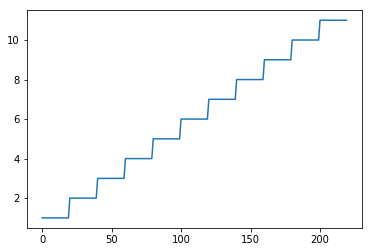

In [86]:
pd.Series(test_y).plot()

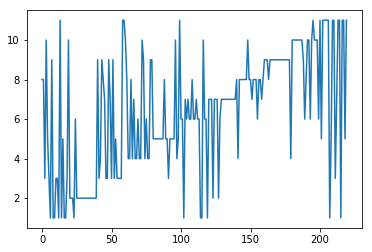

In [87]:
pd.Series(predict_y).plot()

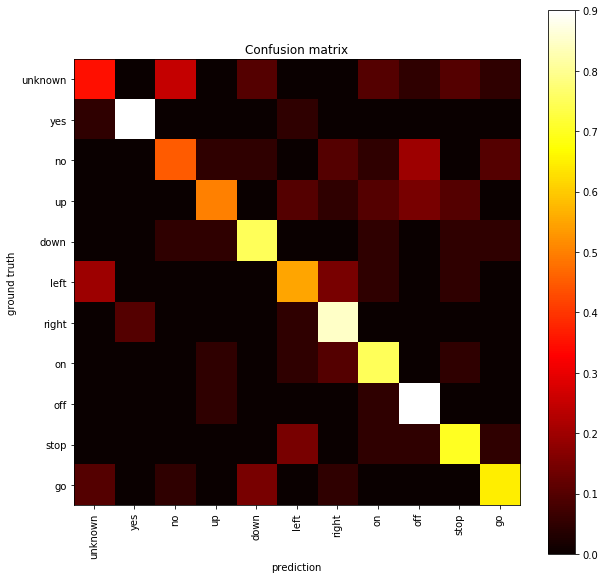

In [88]:
# confusion matrix from ADA
conf_mat=confusion_matrix(test_y,predict_y)

plt.figure(figsize=(10,10))
plt.imshow(conf_mat/np.sum(conf_mat,axis=1),cmap=plt.cm.hot)
tick = np.arange(len(class_names))
plt.xticks(tick, class_names,rotation=90)
plt.yticks(tick, class_names)
plt.ylabel('ground truth')
plt.xlabel('prediction')
plt.title('Confusion matrix')
plt.colorbar()